In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

In [2]:
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'large'
plt.rcParams["figure.figsize"] = (15,7.5)

In [3]:
stock_prices = pd.read_csv('stock_prices.csv', parse_dates=True, index_col='Date')
day_1_returns = pd.read_csv('1_day_returns.csv', parse_dates=True, index_col='Date')
day_10_returns = pd.read_csv('10_days_returns.csv', parse_dates=True, index_col='Date')
daily_log_returns = pd.read_csv('log_returns.csv', parse_dates=True, index_col='Date')
log_10_day_returns = pd.read_csv('log_10_day_returns.csv', parse_dates=True, index_col='Date')

rates = pd.read_csv('rates_interpolated.csv', parse_dates=True, index_col='Date')
rates.columns = rates.columns.astype(float)

vanila_rates = pd.read_csv('rates.csv', parse_dates=True, index_col='Date')
vanila_rates.columns = vanila_rates.columns.astype(float)

# 1. Данные

In [4]:
day_10_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-14,-0.046112,0.033590,-0.033061,0.002551,-0.035911,-0.063063,-0.055305,-0.064180
2009-07-15,0.042874,0.084083,0.017569,0.061363,0.042934,0.011609,0.003324,0.034152
2009-07-16,0.026554,0.059934,0.025769,0.054224,0.036310,-0.016630,0.019411,0.026900
2009-07-17,0.109610,0.069516,0.059996,0.076118,0.021175,0.019244,0.049897,0.142706
2009-07-20,0.099232,0.057434,0.075673,0.111995,0.091039,0.085354,0.064516,0.163021


In [5]:
daily_log_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-02,-0.059875,-0.004317,-0.018642,-0.018222,-0.035043,-0.038942,-0.033347,-0.058686
2009-07-03,-0.007269,0.027306,-0.003541,0.017240,0.023980,0.023082,-0.006671,-0.004432
2009-07-06,-0.050879,-0.014413,-0.026536,-0.005022,-0.020954,-0.029037,-0.020968,-0.072136
2009-07-07,-0.000614,0.011040,0.002354,-0.007432,-0.001501,-0.009601,-0.004110,0.018397
2009-07-08,-0.040118,-0.030875,-0.006003,-0.019484,-0.035316,-0.045646,-0.008270,-0.012843


In [6]:
rates.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,13.5,14.0,14.5,15.0,15.5,16.0,16.5,17.0,17.5,18.0
Date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,9.18,10.56,11.135,11.71,11.815,11.92,11.8825,11.845,11.8075,11.77,...,11.623,11.622,11.621,11.62,11.62,11.62,11.62,11.62,11.62,11.62
2009-07-02,8.93,10.29,10.920,11.55,11.730,11.91,11.9075,11.905,11.9025,11.90,...,11.455,11.440,11.425,11.41,11.41,11.41,11.41,11.41,11.41,11.41
2009-07-03,8.91,10.33,11.005,11.68,11.845,12.01,11.9725,11.935,11.8975,11.86,...,11.411,11.404,11.397,11.39,11.39,11.39,11.39,11.39,11.39,11.39
2009-07-06,8.84,10.20,10.925,11.65,11.900,12.15,12.1725,12.195,12.2175,12.24,...,11.757,11.738,11.719,11.70,11.70,11.70,11.70,11.70,11.70,11.70
2009-07-07,9.09,10.45,11.035,11.62,11.765,11.91,11.8975,11.885,11.8725,11.86,...,11.614,11.606,11.598,11.59,11.59,11.59,11.59,11.59,11.59,11.59


## Метод подсчета доходностей

### Логарифмичские

$$
r_{t+1} = \log\frac{P_{t+1}}{P_{t}}
$$

### Арифметические

$$
r_{t+1} = \frac{P_{t+1} - P_{t}}{P_{t}}
$$

# 2. Описание данных

- Цены закрытия акций выружены с Yahoo Finance.
- Ставки взяты с сайта ЦБ РФ.
- Кросс-валютный курс выгружен с сайта stooq.com, который берет информацию с Google Finance.

Выведим описательные статистики, skew, kurtosis и автокорреляцию по первому лагу арифметических 10-дневных доходностей акций.

In [7]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [8]:
def describe(df):
    """
    Print description of datafame with autocorrelation, skew and kurtosis
    """
    description = df.describe()
    
    colnames = list(df.columns)
    autocorrelation = []
    
    for colname in colnames:
        autocorrelation.append(df[colname].autocorr(lag = 1))
        
    autocorr = pd.DataFrame([autocorrelation], columns = colnames, index=['autocorr'])
    skews = pd.DataFrame([skew(df, axis = 0).tolist()], columns = colnames, index=['skew'])
    kurt = pd.DataFrame([kurtosis(df, axis = 0).tolist()], columns = colnames, index=['kurtosis'])
    
    description = description.append(autocorr)
    description = description.append(skews)
    description = description.append(kurt)
    
    return description

In [9]:
describe(daily_log_returns)

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.000173,-0.000764,-0.000198,0.000128,-0.000502,-0.000800,0.000427,0.000444
std,0.023887,0.030933,0.018482,0.016300,0.035221,0.033601,0.013476,0.024755
min,-0.076172,-0.168794,-0.140368,-0.061640,-0.283638,-0.195471,-0.053226,-0.114285
25%,-0.014169,-0.017052,-0.009557,-0.008810,-0.018900,-0.018744,-0.007538,-0.013972
50%,0.001184,-0.001252,-0.000051,-0.000159,-0.000306,-0.001931,0.000693,0.000828
75%,0.014911,0.016339,0.009352,0.009139,0.018373,0.018677,0.008970,0.015609
max,0.095437,0.161956,0.089487,0.064578,0.204678,0.120018,0.038298,0.076540
autocorr,0.003796,0.014173,0.030910,-0.026055,-0.023473,0.042604,0.056323,0.049168
skew,-0.111088,-0.028955,-0.561599,0.027504,-0.538963,-0.231325,-0.205137,-0.140894


In [10]:
describe(vanila_rates)

,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,5.096688,5.474746,5.806954,6.099099,6.964226,7.506485,8.079683,8.333617,8.494708,8.581954
std,1.531540,1.509381,1.499777,1.494949,1.476348,1.435242,1.334353,1.249837,1.159669,1.071605
min,2.860000,3.390000,3.830000,4.200000,5.440000,6.000000,6.560000,6.880000,7.140000,7.310000
25%,3.740000,4.170000,4.570000,4.917500,5.977500,6.640000,7.410000,7.710000,7.890000,8.020000
50%,4.840000,5.335000,5.770000,6.090000,6.690000,7.050000,7.620000,7.940000,8.170000,8.290000
75%,6.120000,6.232500,6.350000,6.535000,7.300000,7.740000,8.252500,8.482500,8.620000,8.662500
max,8.740000,9.340000,9.970000,10.560000,11.710000,12.160000,12.430000,12.420000,12.230000,12.010000
autocorr,0.997385,0.997438,0.997304,0.997109,0.996775,0.996916,0.996711,0.995841,0.994423,0.993101
skew,0.599426,0.864714,1.121669,1.350469,1.925105,2.148619,2.241309,2.199967,2.112796,2.013835


# 3. VaR и ES для акций

## Дельта-нормальный метод

Проверим остатки на нормальность.

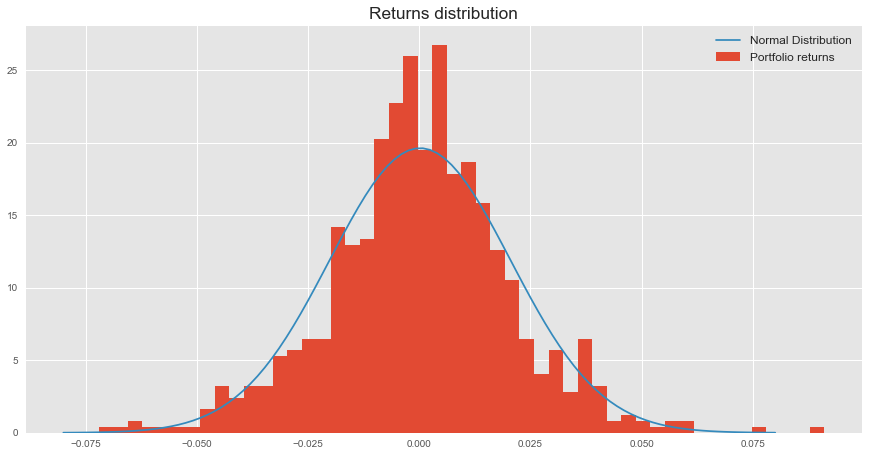

In [11]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
returns_distribution = day_1_returns@p_weights

plt.hist(returns_distribution, density = True, bins=50)
mu = returns_distribution.mean()
std = returns_distribution.std()
x_axis = np.linspace(-0.08, 0.08, 100)
plt.plot(x_axis, stats.norm.pdf(x_axis ,returns_distribution.mean(),returns_distribution.std()))
plt.legend(['Normal Distribution', 'Portfolio returns'])
plt.title('Returns distribution');

In [12]:
p_value = stats.shapiro(returns_distribution)[1]
if p_value <= 0.01:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


Остатки не нормальны, но для упрощения предположим, что они нормально распределены.

Функция использует следующие формулы для подсчета VaR и ES:

$$
VaR_{\alpha}(X) = \sigma_p \cdot \Phi^{-1}(\alpha) \cdot \sqrt{t}
$$

$$
ES_{\alpha}(X) = \sigma_p \cdot \frac{\phi(\Phi^{-1}(\alpha))}{\alpha} \cdot \sqrt{t}
$$

<center>$t$ - holding period</center>

In [13]:
import scipy.stats as st

In [14]:
def delta_norm_stock_VaR_ES(start, end, p_weights, alpha, return_period, daily_log_returns = daily_log_returns):
    cov = np.array(daily_log_returns[start:end].cov())
    stdev_p = np.sqrt(p_weights@cov@p_weights)
    mu_p = (daily_log_returns@p_weights.T).mean()
    
    VaR = stdev_p * st.norm.ppf(1 - alpha) * np.sqrt(return_period)
    ES = stdev_p * st.norm.pdf(st.norm.ppf(1 - alpha))/alpha * np.sqrt(return_period)
    # check how return peroid is included in ES

    return VaR, ES

In [15]:
future_log_returns = log_10_day_returns[log_10_day_returns.index[-1] - dt.timedelta(days = 364):]@p_weights.T

In [16]:
alpha = 0.01

VaR_delta_norm_forecast = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 728), 
                               p_weights, alpha, return_period = 10)[0] for i in range(future_log_returns.shape[0])];
ES_delta_norm_forecast = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 728), 
                               p_weights, alpha, return_period = 10)[1] for i in range(future_log_returns.shape[0])];

VaR_delta_norm_forecast = pd.Series(VaR_delta_norm_forecast, pd.to_datetime(future_log_returns.index))
ES_delta_norm_forecast = pd.Series(ES_delta_norm_forecast, pd.to_datetime(future_log_returns.index))

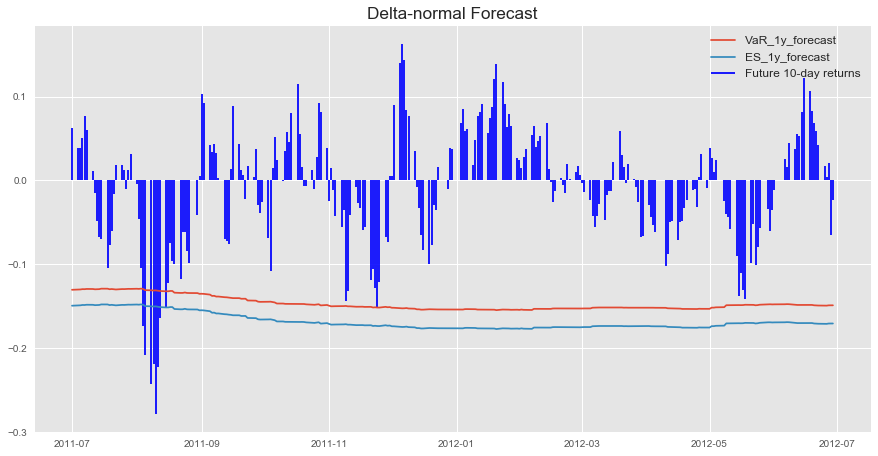

In [17]:
plt.plot(VaR_delta_norm_forecast)
plt.plot(ES_delta_norm_forecast)
plt.vlines(future_log_returns.index, ymax=list(future_log_returns), ymin = 0, colors='b')
plt.legend(['VaR_1y_forecast', 'ES_1y_forecast', 'Future 10-day returns'])
plt.title('Delta-normal Forecast');

## Historical simulation

VaR и ES для Historical simulation считались так:

$$
VaR_\alpha(X) = - inf{[x|P(X \leq x) > \alpha]}
$$

$$
ES_\alpha(X) = \frac{\Sigma [x|P(X \leq x) > \alpha]}{\#x}
$$

In [18]:
def historical_stock_VaR_ES(start, end, p_weights, alpha, returns, plot=False):
    
    #Calculation
    p_returns = returns[start:end]@p_weights.T
    p_returns = p_returns.sort_values()
    
    VaR_location = int(np.floor(p_returns.shape[0] * alpha))
    VaR = - p_returns[VaR_location]
    ES = - p_returns[:VaR_location].mean()
    
    #Plot    
    if plot == True:
#        plt.figure(figsize=(15,7.5))
        plt.tick_params(labelsize=14)
        plt.title('Historical Simulation')
        plt.legend(['Empirical PMF', 'VaR', 'ES'])  
        
        plt.scatter(p_returns, np.linspace(0, 1, p_returns.shape[0]), s = 20)
        plt.scatter(p_returns[VaR_location], np.linspace(0, 1, p_returns.shape[0])[VaR_location], s = 300)
        plt.scatter(p_returns[:VaR_location].mean(), np.linspace(0, 1, p_returns.shape[0])[:VaR_location].mean(), s = 300)
        plt.xlabel('P\L')
        plt.legend(['Empirical PMF', 'VaR', 'ES'])
    
    return VaR, ES

In [19]:
future_stock_10_day_returns = day_10_returns[day_10_returns.index[-1] - dt.timedelta(days = 364):]@p_weights.T

In [20]:
alpha = 0.01

VaR_historical_forecast = [ -historical_stock_VaR_ES(day_10_returns.index[i], 
                                                        day_10_returns.index[i] + dt.timedelta(days = 716), 
                               p_weights, alpha, returns = day_10_returns)[0] 
                           for i in range(future_stock_10_day_returns.shape[0])]
ES_historical_forecast = [ -historical_stock_VaR_ES(day_10_returns.index[i], 
                                                        day_10_returns.index[i] + dt.timedelta(days = 716), 
                               p_weights, alpha, returns = day_10_returns)[1] 
                          for i in range(future_stock_10_day_returns.shape[0])]

VaR_historical_forecast = pd.Series(VaR_historical_forecast, pd.to_datetime(future_stock_10_day_returns.index))
ES_historical_forecast = pd.Series(ES_historical_forecast, pd.to_datetime(future_stock_10_day_returns.index))

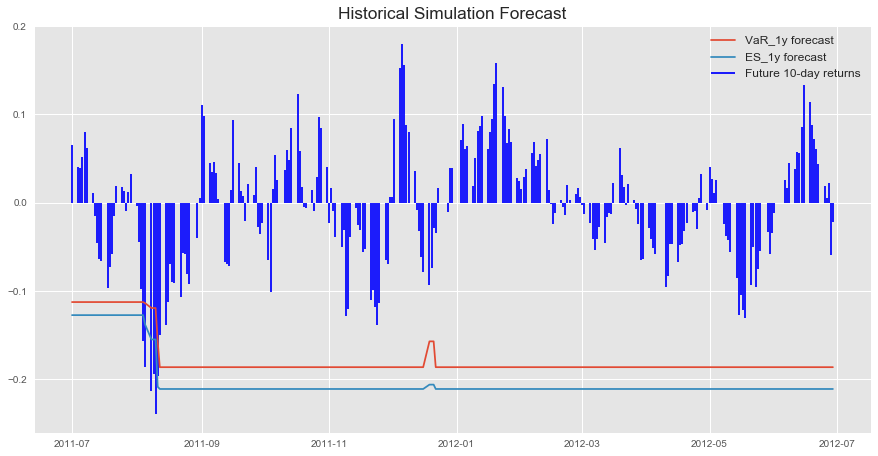

In [21]:
plt.plot(VaR_historical_forecast)
plt.plot(ES_historical_forecast)
plt.vlines(future_stock_10_day_returns.index, ymax=list(future_stock_10_day_returns), ymin = 0, colors='b')
plt.legend(['VaR_1y forecast', 'ES_1y forecast', 'Future 10-day returns'])
plt.title('Historical Simulation Forecast');

VaR: C вероятностью 0.99 портфель не потеряет за 10-дневный срок больше чем 11.24% стоимости
ES: Если портфель за 10 дней будет терять больше, чем 11.24% стоимости, то он в среднем потеряет 12.72%


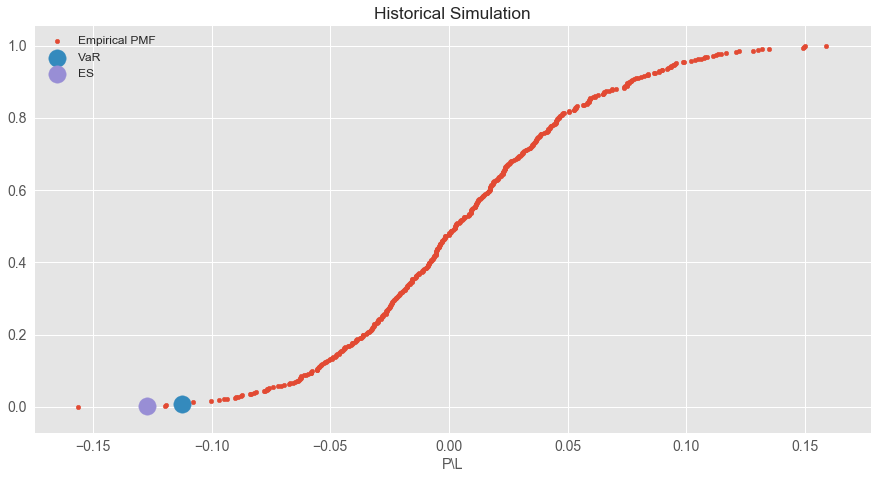

In [22]:
VaR_hist, ES_hist = historical_stock_VaR_ES(day_10_returns.index[0], 
                                            day_10_returns.index[0] + dt.timedelta(716),
                                            p_weights, alpha, plot = True, returns = day_10_returns)

print(f'VaR: C вероятностью {1-alpha} портфель не потеряет за 10-дневный срок больше чем {round(VaR_hist * 100, 2)}% стоимости')
print(f'ES: Если портфель за 10 дней будет терять больше, чем {round(VaR_hist * 100, 2)}% стоимости, то он в среднем потеряет {round(ES_hist*100, 2)}%')

# 4. VaR и ES для облигаций

$$
VaR(\alpha=1\%) = \dfrac{dP}{P}(\alpha=1\%)
$$
$$
VaR(\alpha=1\%) = q_{\Delta r}(\alpha=1\%)*Duration,
$$
$$
Duration = \dfrac{dP}{dr}/P = \dfrac{dP}{Pdr} 
$$

<center>$P$ - цена облигации<center>    
<center>$\Delta r$ - приращение ставки дисконтирования<center>
<center>$q_{\Delta r}(\alpha=1\%)$ - $1\%$-квантиль распределения приращения ставки дисконтирования<center>

Найдем структуру купонных платежей.

In [23]:
class bond():
    """
    Class Bond is used to get structure of payments of bonds with given parameter.
    Bond can be defined in two ways:
        1. Coupon, frequency, maturity, amortization.
        2. Dates and payments.
    
    Properties are:
        .dates - dates as np.array
        .payments - payments as np.array
        .structure - dict of dates as keys ans payments as items     
    """
    def __init__(s, coupon = False, frequency = False, maturity = False, amortization = False, 
                 dates = None, payments = None):

        if dates is not None and payments is not None:
            s.dates = dates
            s.payments = payments           
        else:           
            dates = np.linspace(0, maturity, frequency * maturity + 1)[1:]
            s.dates = dates
            
            if amortization == True:
                amortization = np.ones(maturity*frequency) * (100/(maturity*frequency))
                s.amortization = amortization
                payments = np.linspace(1, 0, maturity*frequency + 1)[:-1] * coupon/frequency + amortization
                s.payments = payments
            else:
                principal = np.zeros(maturity*frequency)
                principal[-1] = 100
                payments = np.ones(frequency * maturity) * coupon/frequency + principal
                s.payments = payments
        
        s.structure = {date: payment for (date, payment) in zip(dates, payments)}

In [24]:
def bond_portfolio(*bonds):     
    """
    A function to get the structure of payments of a portfolio of bonds from a number of bonds.
    Output is a class bond object.
    """
    portfolio = bonds[0].structure
    
    for Bond in bonds[1:]:
        Bond = Bond.structure
        portfolio = {k: portfolio.get(k, 0) + Bond.get(k, 0) for k in set(portfolio) | set(Bond)}   
        
    dates = np.array(list(rates.columns))
    portfolio = {k: portfolio.get(k, 0) + 0 for k in set(portfolio) | set(dates)}
    portfolio = {k: portfolio.get(k, 0) for k in sorted(portfolio)}
    
    payments = np.array(list(portfolio.values()))
    structured_portfolio = bond(dates = dates, payments = payments)
    
    return structured_portfolio

def dcf(bond_portfolio, rates):
    """
    Get DCF of a bond portfolio.
    Input: bond_portfolio as bond class object
           rates as a dataframe of rates on a required period
    Output: Dataframe of DCF
    
    """
    
    dcf = np.ones([rates.shape[0], rates.shape[1]]) * bond_portfolio.payments    
    dcf = dcf * np.exp(-rates/100 * np.array(list(rates.columns)))
    
    return dcf

def duration(bond_portfolio, rates):
    """
    Get duration of a bond portfolio.
    Input: bond_portfolio as bond class object
           rates as a dataframe of rates on a required period
    Output: Series of duration
    
    """
    DCF = dcf(bond_portfolio, rates)
    dates = np.ones([DCF.shape[0], DCF.shape[1]]) * np.array(list(rates.columns))    
    return (DCF * dates).sum(axis = 1) / DCF.sum(axis = 1)

In [25]:
bond1 = bond(coupon = 4.84, frequency = 2, maturity = 2)
bond2 = bond(coupon = 6.14, frequency = 2, maturity = 3)
bond3 = bond(coupon = 5.7, frequency = 2, maturity = 6)
bond4 = bond(coupon = 4.34, frequency = 2, maturity = 10, amortization = True)
bond5 = bond(coupon = 2.28, frequency = 1, maturity = 13, amortization = True)
bond6 = bond(coupon = 4.73, frequency = 1, maturity = 18, amortization = True)

portfolio = bond_portfolio(bond1, bond2, bond3, bond4, bond5, bond6)

DCF = dcf(portfolio, rates)

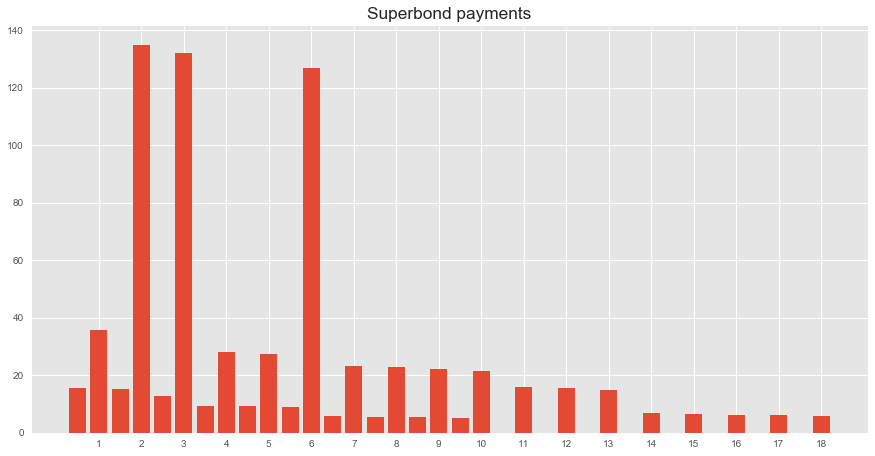

In [76]:
plt.bar(x=portfolio.dates, height=portfolio.payments, width=0.4)
#ticks = portfolio.dates[((portfolio.dates < 10) | (portfolio.dates % 1 == 0))]
ticks = portfolio.dates[(portfolio.dates % 1 == 0)]
plt.xticks(ticks)
plt.title('Superbond payments');

## Дельта-нормальный метод

In [27]:
today_date = '2011-07-01'

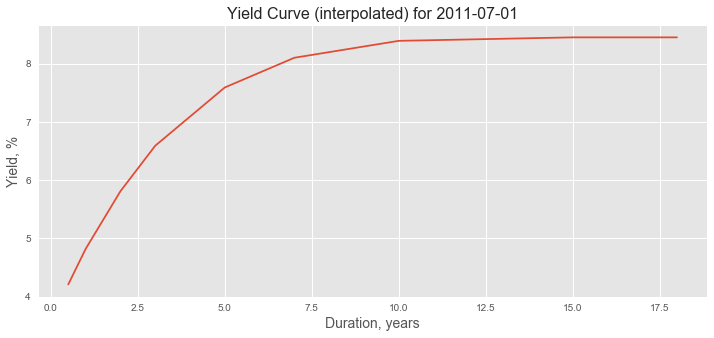

In [28]:
plt.figure(figsize=(12, 5))

plt.plot(rates.T[today_date])
plt.ylabel('Yield, %', fontsize=14)
plt.xlabel('Duration, years', fontsize=14)
plt.title('Yield Curve (interpolated) for ' + str(today_date), fontsize=16);

In [29]:
diff_rates = rates.diff()[1:]
diff_rates_history_today = diff_rates[diff_rates.index <= today_date]

max_increments = diff_rates.max(axis=1)
max_increments_history_today = diff_rates_history_today.max(axis=1)

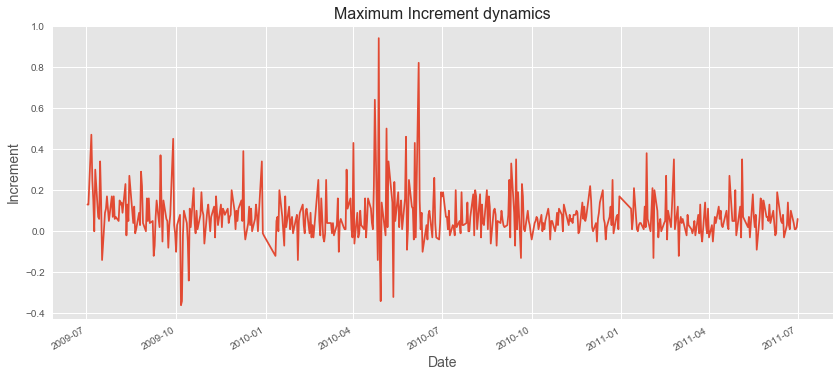

In [30]:
plt.figure(figsize=(14, 6))
max_increments_history_today.plot()
plt.title('Maximum Increment dynamics', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Increment', fontsize=14);

Давайте проверим максимальные приращения доходностей на нормальность.

In [31]:
import scipy.stats as stats

p_value = stats.shapiro(max_increments_history_today)[1]
if p_value <= 0.01:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


In [32]:
alpha = 0.01
z_crit = stats.norm.ppf(1-alpha)

In [33]:
min_obs = len(max_increments[max_increments.index <= today_date])

max_increment_today_future_means = max_increments.expanding(min_obs).mean().dropna()[:-1]
max_increment_today_future_means.index = rates[rates.index > today_date].index # дата - дата прогнозирования бонда

max_increment_today_future_stds = max_increments.expanding(min_obs).std().dropna()[:-1]
max_increment_today_future_stds.index = rates[rates.index > today_date].index

quantiles_today_future = max_increment_today_future_means + max_increment_today_future_stds*z_crit

durations_today_future = duration(portfolio, rates)[duration(portfolio, rates).index >=\
                                                    quantiles_today_future.index[0]]

n_days = 10
VaRs_10days = -(durations_today_future*quantiles_today_future/100)*np.sqrt(n_days)
# Date - дата построения прогноза!

bond_prices = np.sum(DCF, axis=1)

bond_prices_today_future = bond_prices[bond_prices.index >= today_date]
bond_prices_tf_pct_change = bond_prices_today_future.pct_change(periods=10).dropna()

VaRs_10days = VaRs_10days[:-(VaRs_10days.shape[0] - bond_prices_tf_pct_change.shape[0])]

VaRs_10days.index = bond_prices_tf_pct_change.index

ES_10days = -durations_today_future *(quantiles_today_future \
* stats.norm.pdf(stats.norm.ppf(1 - alpha))/alpha*np.sqrt(n_days))/100

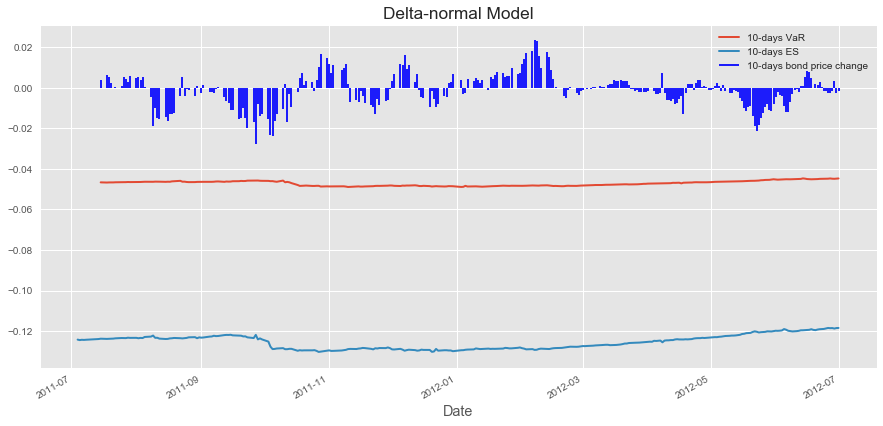

In [34]:
plt.figure(figsize=(15, 7))
VaRs_10days.plot(lw=2)
ES_10days.plot(lw=2)
plt.vlines(bond_prices_tf_pct_change.index, ymax=list(bond_prices_tf_pct_change), ymin = 0, colors='b')

plt.title('Delta-normal Model')
plt.legend(['10-days VaR', '10-days ES', '10-days bond price change'], loc=1, fontsize=10);

## PCA

<h3><center>$X_{250, 10}$</center>
<center> &nbsp </center>
<center>$\Downarrow$</center>
<center> &nbsp </center>
<center>$X_{250, 3}^{PCA}$</center>
<center> &nbsp </center>
<center>$\Downarrow$</center>
<center> &nbsp </center>
<center>$G_{1000, 3}$</center>
<center> &nbsp </center>        
<center>$\Downarrow$</center>
<center> &nbsp </center>
<center>$\widehat{X}_{1000, 10}^{PCA}$</center>
<center> &nbsp </center>
<center>$\Downarrow$</center>
<center> &nbsp </center>
<center>$\widehat{P}_{1000,1}$</center></h3>

In [35]:
from sklearn.decomposition import PCA

In [36]:
def interpolate_df_rates(dataframe):
    
    """
    Function for interpolation of rates. It works only for the current task.
    
    """
    
    seq_1 = np.arange(1.5, 18.5, 1)
    seq_2 = np.arange(4, 5, 1)
    seq_3 = np.arange(6, 7, 1)
    seq_4 = np.arange(8, 10, 1)
    seq_5 = np.arange(11, 15, 1)
    seq_6 = np.arange(16, 19, 1)

    new_cols_float = sorted(np.concatenate([seq_1, seq_2, seq_3, seq_4, seq_5, seq_6], axis=0))

    new_cols_str = ['{:.2f}'.format(x) for x in new_cols_float]

    new_vals = [np.nan]*len(new_cols_str)

    dataframe = dataframe.reindex(columns=dataframe.columns.tolist() + new_cols_str)   # add empty cols
    dataframe[new_cols_str] = new_vals  # multi-column assignment works for existing cols

    dataframe = dataframe.reindex(['{:.2f}'.format(x) for x in sorted(dataframe.columns.astype('float'))], 
                                            axis=1)

    dataframe_interpolated = dataframe.interpolate(method = 'linear',
                                             axis = 1)
    
    return(dataframe_interpolated)

In [37]:
def PCA_transformation(historic_data, needed_variance=0.95, n_monte_carlo = 1000, rand_state=26):
    np.random.seed(rand_state)

    pca_model = PCA(random_state=rand_state)
    
    historic_data_centr = historic_data - historic_data.mean(axis=0)

    pca_model.fit_transform(historic_data_centr)
    best_n_components = np.sum(np.cumsum(pca_model.explained_variance_ratio_) < needed_variance)+1 
    # число компонент для дисперсии больше 0.95

    pca_model_best = PCA(n_components=best_n_components)
    historic_data_transformed = pca_model_best.fit_transform(historic_data_centr)
    historic_data_transformed = pd.DataFrame(historic_data_transformed,
                                                      index=historic_data.index)

    n_sample = n_monte_carlo
    norm_random_factors = np.zeros((1000, best_n_components))

    i = 0
    for col in historic_data_transformed.columns:
        norm_random_factors[:, i] = np.random.normal(historic_data_transformed.mean()[i],
                                    historic_data_transformed.std()[i], n_sample)
        i += 1

    historic_mean_data_matrix = np.ones([n_monte_carlo, historic_data.shape[1]]).T@historic_data.mean(axis=0)
    full_transformed_increments = pd.DataFrame(norm_random_factors@pca_model_best.components_) + np.ones([n_monte_carlo, historic_data.shape[1]]) * np.array(historic_data.mean())
    full_transformed_increments.columns=list(historic_data.columns)
    
    return full_transformed_increments, best_n_components # обратно к доходностям!

In [38]:
def bond_pca_VaRs(rates, transformed_increments, n_days, rates_names, bond_payments, percentile=0.01,
                 include_ES = False):
    
    VaRs = []
    
    if include_ES:
        ESs = []

    for i in range(rates.shape[0]-n_days):

        # цена бонда на сегодня
        today_price = float((np.exp(-(np.array(rates.iloc[i])/100)*np.array(list(rates_names))))\
                                                                @ bond_payments)

        # сценарии ставок на следующий день
        rates_scenario = np.tile(rates.iloc[i],
                                 (transformed_increments.shape[0],1))\
        + transformed_increments 

        scenario_bond_prices = np.exp(-(np.array(rates_scenario)/100)*np.array(list(rates_names)))\
                                                                                @ bond_payments

        quantile_price = sorted(scenario_bond_prices)[int(len(scenario_bond_prices)*percentile - 1)] 
        quantile_loss = (quantile_price - today_price)/today_price
        VaRs.append(quantile_loss)
        
        if include_ES:
            quantile_expected_price = np.mean(sorted(scenario_bond_prices)[:int(1000*0.01)])
            quantile_expected_loss = (quantile_expected_price - today_price)/today_price
            ESs.append(quantile_expected_loss)
    
    if include_ES:
        return VaRs, ESs

    else:
        return VaRs

In [39]:
pca_rates = pd.read_csv('rates.csv', parse_dates=['Date'], index_col='Date').drop(['0.25', '0.75'], axis=1)
pca_rates.head()

,0.50,1.00,2.00,3.00,5.00,7.00,10.00,15.00
Date,,,,,,,,
2009-07-01,9.18,10.56,11.71,11.92,11.77,11.65,11.63,11.62
2009-07-02,8.93,10.29,11.55,11.91,11.90,11.74,11.56,11.41
2009-07-03,8.91,10.33,11.68,12.01,11.86,11.62,11.46,11.39
2009-07-06,8.84,10.20,11.65,12.15,12.24,12.09,11.89,11.70
2009-07-07,9.09,10.45,11.62,11.91,11.86,11.76,11.67,11.59


In [40]:
pca_rates_history_today = pca_rates[pca_rates.index <= today_date]
pca_rates_today_future = pca_rates[pca_rates.index >= today_date]

pca_diff_rates = pca_rates.diff(periods=10).dropna()
pca_diff_rates_history_today = pca_diff_rates[pca_diff_rates.index <= today_date]

In [41]:
full_transformed_increments = PCA_transformation(pca_diff_rates_history_today)[0]

full_interp_transformed_increments = interpolate_df_rates(pd.DataFrame(full_transformed_increments))
# это матрица сценариев инкрементов на 10 дней, 
#которую применяем ко всем ставкам

pca_rates_today_future_interpolated = interpolate_df_rates(pca_rates_today_future)

pca_VaRs = bond_pca_VaRs(pca_rates_today_future_interpolated, full_interp_transformed_increments, n_days=10, 
              rates_names=rates.columns, bond_payments=portfolio.payments, percentile=0.01,
             include_ES=True)[0]

pca_ESs = bond_pca_VaRs(pca_rates_today_future_interpolated, full_interp_transformed_increments, n_days=10, 
              rates_names=rates.columns, bond_payments=portfolio.payments, percentile=0.01,
             include_ES=True)[1]

pca_VaRs = pd.Series(pca_VaRs)
pca_VaRs.index = bond_prices_tf_pct_change.index

pca_ESs = pd.Series(pca_ESs)
pca_ESs.index = bond_prices_tf_pct_change.index

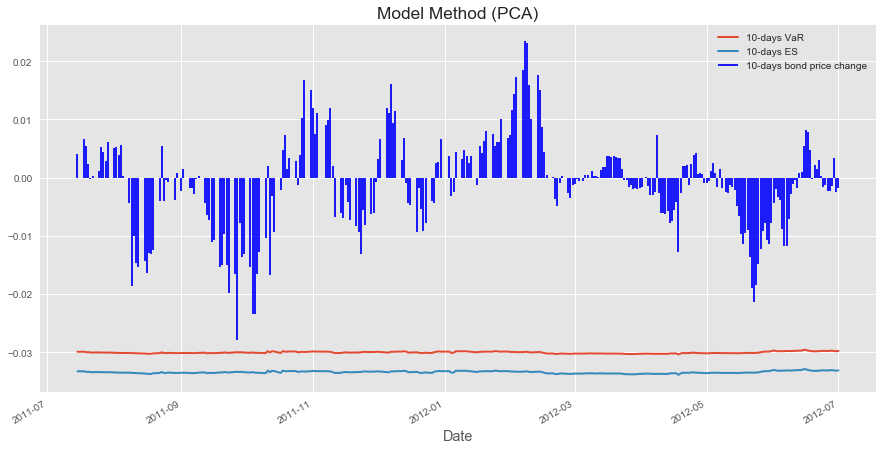

In [42]:
plt.figure(figsize=(15,7.5))
pca_VaRs.plot(lw=2)
pca_ESs.plot(lw=2)
plt.vlines(bond_prices_tf_pct_change.index, ymax=list(bond_prices_tf_pct_change), ymin = 0, colors='b')

plt.title('Model Method (PCA)')
plt.legend(['10-days VaR', '10-days ES', '10-days bond price change'], loc=1, fontsize=10);

# 5. Учет валютного риска

In [43]:
exchange = pd.read_csv('rubgbp.csv', parse_dates=['Date'], index_col='Date')
exchange.columns = ['RUBGBP']
exchange.head() # фунтов за 100 рублей

,RUBGBP
Date,
2009-07-01,1.9526
2009-07-02,1.9635
2009-07-03,1.9543
2009-07-06,1.9701
2009-07-07,1.9598


In [44]:
exchange_today_future = exchange[exchange.index.isin(pca_rates_today_future_interpolated.index)]
# только совпадающие даты в будущем

pca_exchange_rates = pd.concat([exchange, rates], axis=1).fillna(method='ffill') # заполним пропуски предыд. знач.

pca_exchange_rates_history_today = pca_exchange_rates[pca_exchange_rates.index <= today_date]
pca_exchange_rates_today_future = pca_exchange_rates[pca_exchange_rates.index >= today_date]

pca_exchange_today_future = exchange[exchange.index >= today_date]

exchange_log_returns = np.log(exchange/exchange.shift(n_days))[n_days:]

pca_diff_exchange_rates = pd.concat([exchange_log_returns, pca_diff_rates],
                                    axis=1).fillna(method='ffill') # заполним пропуски предыд. знач.

pca_diff_exchange_rates_history_today = pca_diff_exchange_rates[pca_diff_exchange_rates.index <= today_date]
pca_diff_exchange_rates_today_future = pca_diff_exchange_rates[pca_diff_exchange_rates.index >= today_date]

full_transformed_increments_exchange = PCA_transformation(pca_diff_exchange_rates_history_today)[0]

RUBGBP_transformed = full_transformed_increments_exchange['RUBGBP']

full_interp_transformed_increments_only_rates = interpolate_df_rates(
    pd.DataFrame(full_transformed_increments_exchange).drop('RUBGBP', axis=1))

full_interp_transformed_increments_exchange = \
pd.concat([RUBGBP_transformed, full_interp_transformed_increments_only_rates], axis=1)
# это матрица сценариев инкрементов на 10 дней, 
#которую применяем ко всем ставкам

# берем только совпадающие даты
pca_rates_tf_interp_forex = pca_rates_today_future_interpolated[pca_rates_today_future_interpolated.index.isin(
    exchange_today_future.index)]

bond_prices_tf_pct_change_forex = bond_prices_tf_pct_change[bond_prices_tf_pct_change.index.isin(
    exchange_today_future.index)]

In [45]:
pca_cur_VaRs = []
pca_cur_ESs = []

for i in range(pca_rates_tf_interp_forex.shape[0]-n_days):
    
    # сценарии валютного курса через 10 дней
    
    exchange_scenario = ((np.exp(np.array(RUBGBP_transformed)) * np.array(exchange_today_future.iloc[i]))/100)
    
    # цена бонда на сегодня
    today_price = float((np.exp(-(np.array(pca_rates_tf_interp_forex.iloc[i])/100)\
                                                            *np.array(list(rates.columns))))\
                                                            @ portfolio.payments\
                                                            * np.array(exchange_today_future.iloc[i])/100)

    # сценарии ставок через 10 дней
    rates_scenario = np.tile(pca_rates_tf_interp_forex.iloc[i],
                             (full_interp_transformed_increments_only_rates.shape[0],1))\
    + full_interp_transformed_increments_only_rates 
    
    scenario_bond_prices = np.exp(-(np.array(rates_scenario)/100)*np.array(list(rates.columns)))\
                                                                            @ portfolio.payments
    
    scenario_bond_cur_prices = scenario_bond_prices * exchange_scenario
    
    quantile_price = float(sorted(scenario_bond_cur_prices)[int(1000*0.01 - 1)])
    quantile_expected_price = float(np.mean(sorted(scenario_bond_cur_prices)[:int(1000*0.01)]))
    
    quantile_loss = (quantile_price - today_price)/today_price
    pca_cur_VaRs.append(quantile_loss) # получаем VaR
    
    quantile_expected_loss = (quantile_expected_price - today_price)/today_price
    pca_cur_ESs.append(quantile_expected_loss) # получаем ES

pca_cur_VaRs = pd.Series(pca_cur_VaRs)
pca_cur_VaRs.index = bond_prices_tf_pct_change_forex.index

pca_cur_ESs = pd.Series(pca_cur_ESs)
pca_cur_ESs.index = bond_prices_tf_pct_change_forex.index

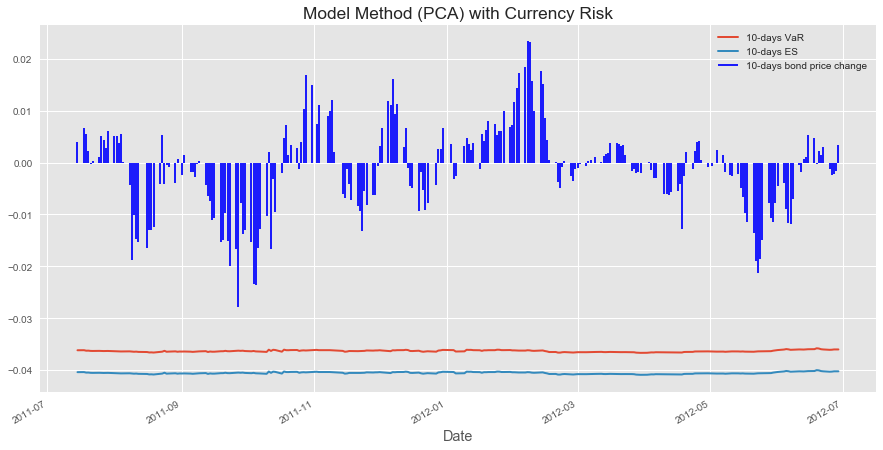

In [46]:
plt.figure(figsize=(15,7.5))
pca_cur_VaRs.plot(lw=2)
pca_cur_ESs.plot(lw=2)
plt.vlines(bond_prices_tf_pct_change_forex.index, ymax=list(bond_prices_tf_pct_change_forex), ymin = 0, colors='b')

plt.title('Model Method (PCA) with Currency Risk')
plt.legend(['10-days VaR', '10-days ES', '10-days bond price change'], loc=1, fontsize=10);

# 6. Backtesting

## Подпортфель акций

Найдем доходности портфеля, на которых будем проводить бэктестинг.

In [47]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
historic_stock_log_returns = (daily_log_returns@p_weights.T)[daily_log_returns.index[252]:daily_log_returns.index[504]]

### Дельта-нормальный метод

In [48]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
return_period = 10
alpha = 0.01

VaR_delta_norm_backtesting = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, return_period = 1)[0] for i in range(historic_stock_log_returns.shape[0])]
ES_delta_norm_backtesting = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, return_period = 1)[1] for i in range(historic_stock_log_returns.shape[0])];

VaR_delta_norm_backtesting = pd.Series(VaR_delta_norm_backtesting, pd.to_datetime(historic_stock_log_returns.index))
ES_delta_norm_backtesting = pd.Series(ES_delta_norm_backtesting, pd.to_datetime(historic_stock_log_returns.index))

Количество пробитий: 0


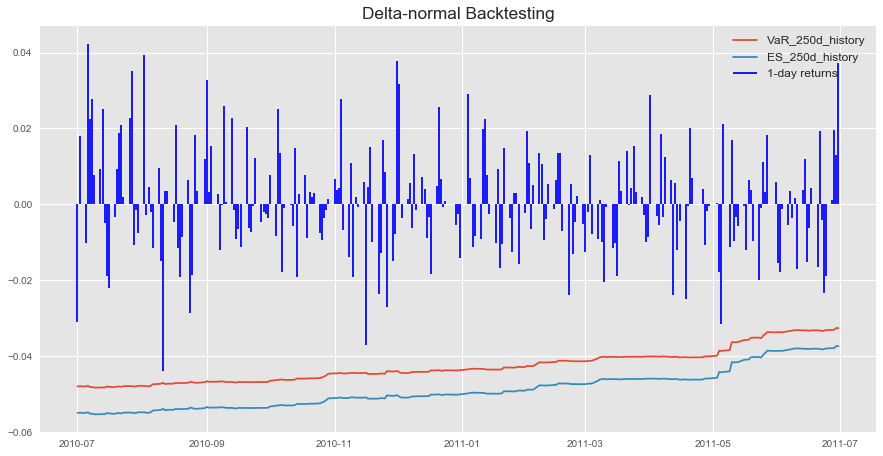

In [49]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_delta_norm_backtesting);
plt.plot(ES_delta_norm_backtesting);
plt.vlines(historic_stock_log_returns.index, ymax=list(historic_stock_log_returns), ymin = 0, colors='b')
plt.legend(['VaR_250d_history', 'ES_250d_history', '1-day returns'])
plt.title('Delta-normal Backtesting');
print("Количество пробитий:", (historic_stock_log_returns < VaR_delta_norm_backtesting).sum())

### Historical simulation

In [50]:
historics_stock_1_day_returns = (day_1_returns@p_weights.T)[day_1_returns.index[252]:day_1_returns.index[504]]

In [51]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
alpha = 0.01

VaR_historical_backtesting = [ -historical_stock_VaR_ES(day_1_returns.index[i], 
                                                        day_1_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, returns = day_1_returns)[0] for i in range(historics_stock_1_day_returns.shape[0])]
ES_historical_backtesting = [ -historical_stock_VaR_ES(day_1_returns.index[i], 
                                                        day_1_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, returns = day_1_returns)[1] for i in range(historics_stock_1_day_returns.shape[0])]

VaR_historical_backtesting = pd.Series(VaR_historical_backtesting, pd.to_datetime(historics_stock_1_day_returns.index))
ES_historical_backtesting = pd.Series(ES_historical_backtesting, pd.to_datetime(historics_stock_1_day_returns.index))

Количество пробитий: 0


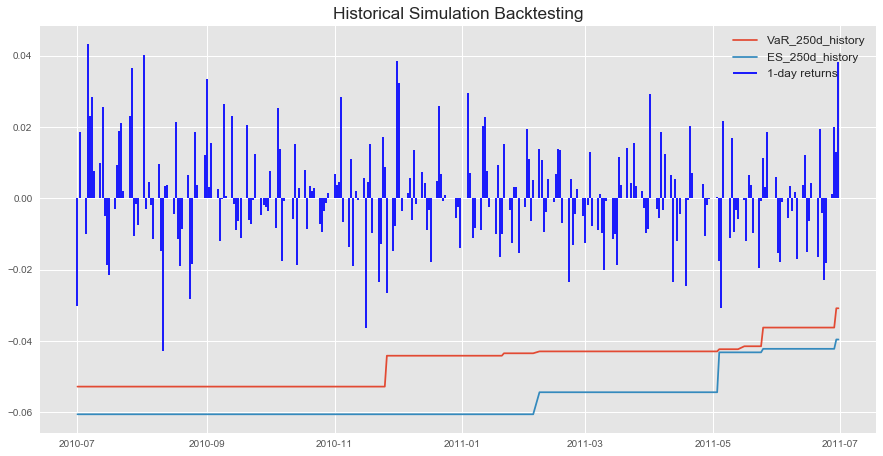

In [52]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_historical_backtesting)
plt.plot(ES_historical_backtesting)
plt.vlines(historics_stock_1_day_returns.index, ymax=list(historics_stock_1_day_returns), ymin = 0, colors='b')
plt.legend(['VaR_250d_history', 'ES_250d_history', '1-day returns'])
plt.title('Historical Simulation Backtesting');
print("Количество пробитий:", (historics_stock_1_day_returns < VaR_historical_backtesting).sum())

## Подпортфель облигаций

### Дельта-нормальный метод

In [53]:
new_today_date = '2010-07-01'

In [54]:
diff_rates = rates.diff()[1:]
historic_diff_rates = diff_rates[diff_rates.index <= new_today_date]

max_increments = diff_rates.max(axis=1)
historic_max_increments = historic_diff_rates.max(axis=1)

In [55]:
p_value = stats.shapiro(max_increments_history_today)[1]
if p_value <= 0.01:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


In [56]:
min_obs_backtest = len(max_increments[max_increments.index <= new_today_date])

backtest_max_increment_means = max_increments[max_increments.index < today_date
                                             ].expanding(min_obs_backtest).mean().dropna()[:-1]
backtest_max_increment_means.index = rates[(rates.index > new_today_date)&
                                           (rates.index < today_date)].index # дата - дата прогнозирования бонда

backtest_max_increment_stds = max_increments[max_increments.index < today_date].expanding(min_obs_backtest).std().dropna()[:-1]
backtest_max_increment_stds.index = rates[(rates.index > new_today_date) & (rates.index < today_date)].index

backtest_quantiles = backtest_max_increment_means + backtest_max_increment_stds*z_crit

backtest_durations = duration(portfolio, rates)[(duration(portfolio, rates).index >=backtest_quantiles.index[0])
                                               & (duration(portfolio, rates).index < today_date)]

VaRs_1day_backtest = -(backtest_durations*backtest_quantiles/100)
# Date - дата построения прогноза!

bond_prices = np.sum(DCF, axis=1)

backtest_bond_prices = bond_prices[(bond_prices.index >= new_today_date) & (bond_prices.index < today_date)]
backtest_bond_prices_pct_change = backtest_bond_prices.pct_change(periods=1).dropna()

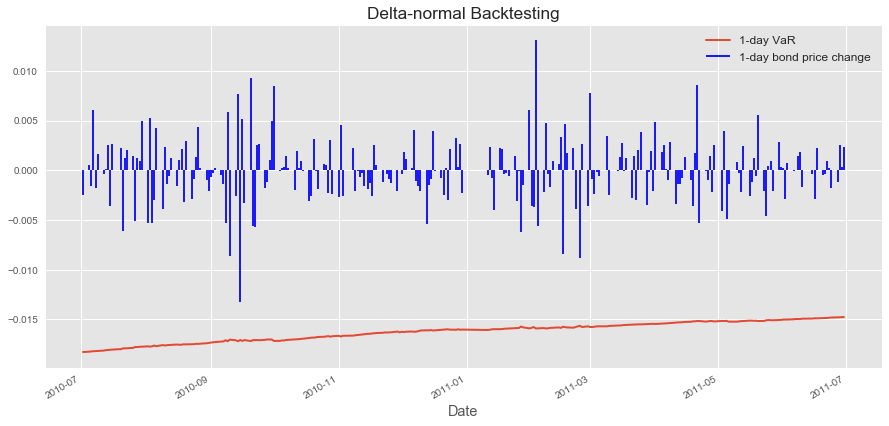

In [57]:
plt.figure(figsize=(15, 7))
VaRs_1day_backtest.plot(lw=2)
plt.vlines(backtest_bond_prices_pct_change.index, ymax=list(backtest_bond_prices_pct_change), ymin = 0, colors='b')

plt.title('Delta-normal Backtesting')
plt.legend(['1-day VaR', '1-day bond price change'], loc=1);

### Модельный VaR

In [58]:
historic_pca_rates = pca_rates[pca_rates.index <= new_today_date]
backtest_pca_rates = pca_rates[(pca_rates.index >= new_today_date) & (pca_rates.index < today_date)]

pca_diff_rates_1d = pca_rates.diff(periods=1).dropna()
historic_pca_diff_rates = pca_diff_rates_1d[pca_diff_rates_1d.index <= new_today_date]

In [59]:
historic_pca_diff_rates.mean()/historic_pca_diff_rates.std()

0.50    -0.164255
1.00    -0.173570
2.00    -0.160601
3.00    -0.147097
5.00    -0.122729
7.00    -0.107174
10.00   -0.099407
15.00   -0.096216
dtype: float64

In [60]:
full_transformed_increments_backtest = PCA_transformation(historic_pca_diff_rates)[0]

In [61]:
backtest_interp_transformed_increments = interpolate_df_rates(pd.DataFrame(full_transformed_increments_backtest))
# это матрица сценариев инкрементов на 10 дней, 
#которую применяем ко всем ставкам

In [62]:
backtest_pca_rates_interpolated = interpolate_df_rates(backtest_pca_rates)

In [63]:
pca_VaRs_backtest = bond_pca_VaRs(backtest_pca_rates_interpolated, backtest_interp_transformed_increments,
                                    n_days=1, rates_names=rates.columns, bond_payments=portfolio.payments)

In [64]:
pca_VaRs_backtest = pd.Series(pca_VaRs_backtest)
pca_VaRs_backtest.index = backtest_bond_prices_pct_change.index

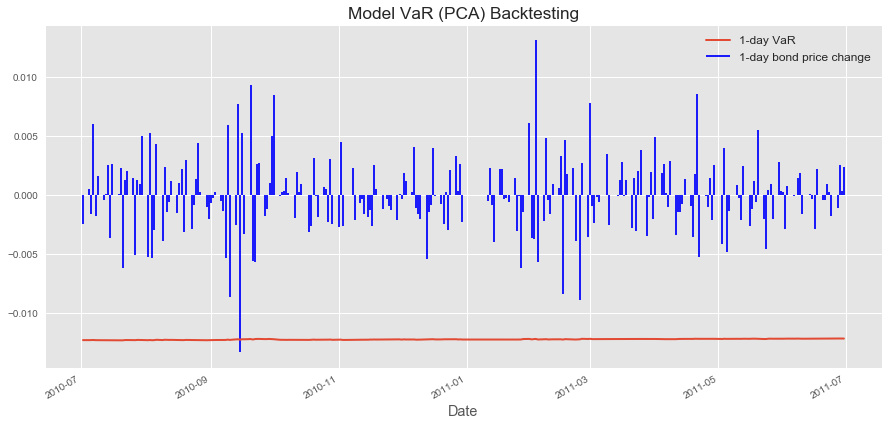

In [65]:
plt.figure(figsize=(15, 7))
pca_VaRs_backtest.plot(lw=2)
plt.vlines(backtest_bond_prices_pct_change.index, ymax=list(backtest_bond_prices_pct_change), ymin = 0, colors='b')

plt.title('Model VaR (PCA) Backtesting')
plt.legend(['1-day VaR', '1-day bond price change'], loc=1);

## Портфель

In [66]:
portfolio_VaR = pd.concat([VaR_historical_backtesting, pca_VaRs_backtest], axis=1)
portfolio_VaR = portfolio_VaR.interpolate(axis = 0)
portfolio_VaR = portfolio_VaR[1:]

portfolio_returns = pd.concat([backtest_bond_prices_pct_change, historics_stock_1_day_returns], axis=1)
portfolio_returns = portfolio_returns.interpolate(axis = 0)
portfolio_returns = portfolio_returns[1:]

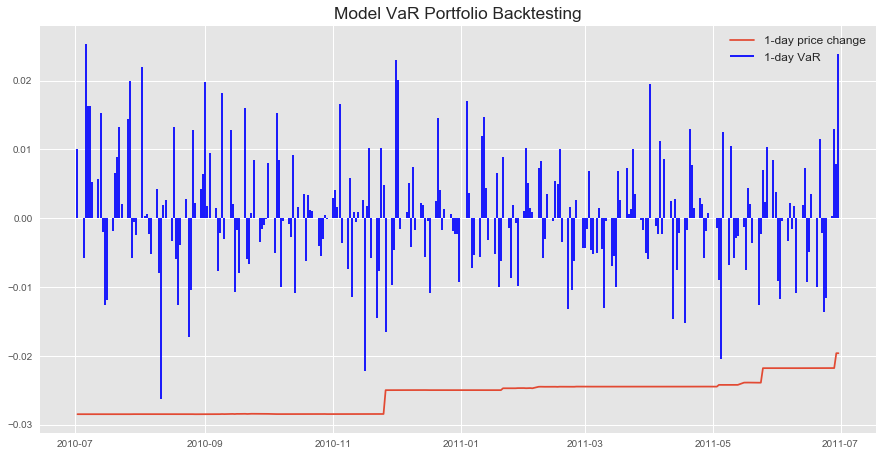

In [74]:
plt.figure(figsize=(15,7.5))
plt.vlines(portfolio_returns.index, ymax=list(portfolio_returns@np.array([0.4, 0.6])), ymin = 0, colors='b')
plt.plot(portfolio_VaR@np.array([0.4, 0.6]))

plt.title('Model VaR Portfolio Backtesting')
plt.legend(['1-day price change', '1-day VaR'], loc=1);

# 7. Задача c лимитом

## Формулировка задачи

$$
0.9 \cdot VaR_t - q_\alpha(max(\Delta r_t)) \cdot D_t^p = 0 
$$

<center>где $t - 13.02.2012$ <center>
<center>$D_t^p = \Sigma_{i = 1}^{6}w_i D_i$ - дюрация портфеля<center>

## Ограничения

<center>$\Sigma_{i = 1}^{6}w_i = 1$<center>

<center>$w_i \in (0, 1)$<center>

## Что было вначале?

Посчитаем дюрации бондов, VaR на дату и найдем 99% перцентиль ставки.

In [68]:
check_date = dt.date(year = 2012, month = 2, day = 13)

bond_prices_limit = np.array([dcf(bond_portfolio(bond1), rates[check_date:check_date]).sum(axis=1)[0],
                 dcf(bond_portfolio(bond2), rates[check_date:check_date]).sum(axis=1)[0],
                 dcf(bond_portfolio(bond3), rates[check_date:check_date]).sum(axis=1)[0],
                 dcf(bond_portfolio(bond4), rates[check_date:check_date]).sum(axis=1)[0],
                 dcf(bond_portfolio(bond5), rates[check_date:check_date]).sum(axis=1)[0],
                 dcf(bond_portfolio(bond6), rates[check_date:check_date]).sum(axis=1)[0]])

durations = np.array([duration(bond_portfolio(bond1), rates[check_date:check_date])[0], 
                      duration(bond_portfolio(bond2), rates[check_date:check_date])[0],
                      duration(bond_portfolio(bond3), rates[check_date:check_date])[0],
                      duration(bond_portfolio(bond4), rates[check_date:check_date])[0],
                      duration(bond_portfolio(bond5), rates[check_date:check_date])[0],
                      duration(bond_portfolio(bond6), rates[check_date:check_date])[0]])

In [71]:
p_duration = duration(portfolio, rates[check_date:check_date])[0]
diff_rates_to_limit = diff_rates[diff_rates.index <= '2012-02-13']
max_increment_to_limit = diff_rates_to_limit.max(axis=1)
quantile_to_limit = max_increment_to_limit.mean() + max_increment_to_limit.std()*z_crit
var_check_date = p_duration*quantile_to_limit/100*np.sqrt(10)

In [80]:
print('Веса на', check_date, ':', bond_prices_limit/bond_prices_limit.sum())
print('Дюрация на', check_date, ':', durations)
print('VaR на',  check_date, ':', np.round(-var_check_date, 3))

Веса на 2012-02-13 : [0.18462519 0.18661749 0.17324746 0.16554183 0.13753522 0.15243281]
Дюрация на 2012-02-13 : [1.92849592 2.78068056 5.10108088 4.29963298 5.59931594 6.58660059]
VaR на 2012-02-13 : -0.048


In [70]:
from scipy.optimize import minimize

In [72]:
def loss(w):
    return var_check_date * 0.9 - quantile_to_limit * durations@w/100*np.sqrt(10)

cons = ({'type': 'eq', 'fun' : lambda w: np.sum(w) - 1.0},
        {'type': 'eq', 'fun' : loss})

b = (0.01, 0.99)
bounds = (b, b, b, b, b, b)

w0 = np.random.rand(6)
res = minimize(loss, w0, method='SLSQP', constraints=cons, bounds = bounds, options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.420153875388632e-09
            Iterations: 2
            Function evaluations: 16
            Gradient evaluations: 2


In [73]:
weights = res.x

print('Optimal weights:', weights)

Optimal weights: [0.15089661 0.43182161 0.01       0.01       0.38728178 0.01      ]


Решений бесконечное множество, но заметно, что оптимизатор снижает веса у бондов с более высокой дюрацией и наоборот.